In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [4]:
# importing the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


In [5]:
df = pd.read_csv("../Dataset/model_building/train/news_headlines_train.csv")

In [6]:
# Testing the tokenizer

text = ["this is a test of the bert model", "thank you for the meeting today"]

sent_id = tokenizer.batch_encode_plus(text, padding=True, max_length = 8)


print(sent_id)


{'input_ids': [[101, 2023, 2003, 1037, 3231, 1997, 1996, 14324, 2944, 102], [101, 4067, 2017, 2005, 1996, 3116, 2651, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [7]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['sentiment'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=df['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Tokenize Sentences

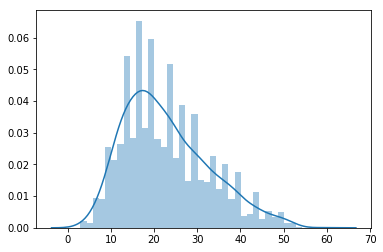

In [10]:
sent_length = [len(x.split()) for x in train_text]

sns.distplot(sent_length, bins = 40)

In [11]:
MAX_LENGTH = 40

In [12]:
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length = MAX_LENGTH, 
                                          pad_to_max_length = True, truncation = True)

tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length = MAX_LENGTH, 
                                          pad_to_max_length = True, truncation = True)

tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length = MAX_LENGTH, 
                                          pad_to_max_length = True, truncation = True)

/Users/Daniel/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {

    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
   'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [10]:
# dataset = "../Dataset"

# dataset_dir = os.path.join(dataset, "model_building" )

# train_dir = os.path.join(dataset_dir, "train")

# name = "news_headlines_train.csv"

# df = pd.read_csv(os.path.join(train_dir, name))

# remove unused folders to make it easier to load the data
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [33]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['sentiment'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['sentiment'])


# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)

In [34]:
df.head()

,text,sentiment
0,"In addition , a further 29 employees can be la...",-1
1,The authorisation is in force until the end of...,0
2,The value of the deal was not disclosed .,0
3,You need to be ready when the window opens up ...,0
4,Major Order in India Comptel Corporation has r...,1


In [12]:
# AUTOTUNE = tf.data.AUTOTUNE
# batch_size = 32
# seed = 42

# raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
#     '../Dataset/model_building/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='training',
#     seed=seed)

# class_names = raw_train_ds.class_names
# train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# val_ds = tf.keras.preprocessing.text_dataset_from_directory(
#     '../Dataset/model_building/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='validation',
#     seed=seed)

# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# test_ds = tf.keras.preprocessing.text_dataset_from_directory(
#     'aclImdb/test',
#     batch_size=batch_size)

# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {

    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
   'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [28]:
df.iloc[0, 0]

'In addition , a further 29 employees can be laid off until further notice and the whole workforce can be laid off for short periods if needed .'

In [24]:
text_test = df.iloc[0:10, 0].to_numpy()

In [26]:
text_preprocessed = bert_preprocess_model(text_test)

In [27]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (10, 128)
Word Ids   : [ 101 1999 2804 1010 1037 2582 2756 5126 2064 2022 4201 2125]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)